In [4]:
# KVM에서 발생하는 VMEXIT 중 page fault로 인한 것을 확인하기 위한 그래프
from parse import *
import numpy as np
import matplotlib.pyplot as plt

start_time = 0
end_time = 0
pf_time = 0
cpu = [] 

# timestamp in <secs>.<usecs> format
#f1 = open("./recognition_ssd.trace", 'r')
#f1 = open("./recognition_nvme.trace", 'r')
f1 =  open("./recognition_faasnap.trace", 'r')
#f2 = open("./recognition_dcpm.trace", 'r')

file_list = [f1]

while True:
    line = f1.readline()
    if not line: break

    if 'restart' in line:
        # fc_vcpu 0-552219  [040] .... 97836.519114: kvm_userspace_exit: reason restart (4)
        if start_time == 0:
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_userspace_exit: {}", line)
            start_time = int(result['sec']) * 1000000 + int(result['micro'])
        elif end_time == 0:
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_userspace_exit: {}", line)
            end_time = int(result['sec']) * 1000000 + int(result['micro'])
            

    if 'fc_vcpu 0' in line:
        if 'kvm_entry' in line:
            #fc_vcpu 0-2779478 [077] d... 1820822.383974: kvm_entry: vcpu 0
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_entry: {}", line)
            cpu_active = {'start': int(result['sec']) * 1000000 + int(result['micro']), 'end': 0, 'reason':''}
            cpu.append(cpu_active)


        if 'kvm_exit' in line:
            #fc_vcpu 0-2779478 [077] .... 1820822.383989: kvm_exit: vcpu 0 reason EPT_VIOLATION rip 0x5a1b20 info 384 0
            result = parse("       fc_vcpu {no}-{} [{}] {} {sec}.{micro}: kvm_exit: {} reason {reason} rip {}", line)
            # if result['reason'] == 'EPT_VIOLATION':
            reason = result['reason']
            if cpu[-1]['end'] == 0:
                cpu[-1]['reason'] = reason
                cpu[-1]['end'] = int(result['sec']) * 1000000 + int(result['micro'])
            else:
                print(line)
                print("vcpu exit가 더 빠름")

f1.close()


FileNotFoundError: [Errno 2] No such file or directory: './recognition_faasnap.trace'

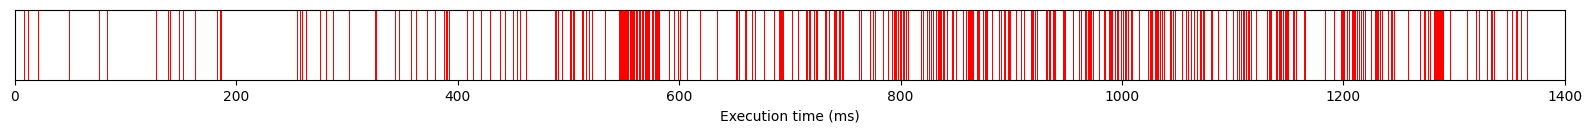

In [ ]:
fig = plt.figure(figsize=(20,2)) ## 캔버스 생성
fig.set_facecolor('white') ## 배경색 설정

plt.subplot(2, 1, 1)                # nrows=2, ncols=1, index=1

plt.xlabel("Execution time (ms)")
plt.ylabel("VM EXIT")
plt.xlim(0, 1400)

plt.gca().axes.yaxis.set_visible(False)

for cpu_active in cpu:
    #cpu_active['start'] = (cpu_active['start'] - start_time) 
    #cpu_active['end'] = (cpu_active['end'] - start_time)
    cpu_active['start'] = (cpu_active['start'] - start_time) * 0.001
    cpu_active['end'] = (cpu_active['end'] - start_time) * 0.001
    #pf_time.append(cpu_active['end'] - cpu_active['start'])
    if cpu_active['reason'] == "EPT_VIOLATION":
        plt.axvspan(cpu_active['start'], cpu_active['end'], facecolor='red')

